# Introduction

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
orig_df = pd.read_stata('./hsbdemo.dta')
orig_df.head()

,id,female,ses,schtyp,prog,read,write,math,science,socst,honors,awards,cid
0,45.0,female,low,public,vocation,34.0,35.0,41.0,29.0,26.0,not enrolled,0.0,1
1,108.0,male,middle,public,general,34.0,33.0,41.0,36.0,36.0,not enrolled,0.0,1
2,15.0,male,high,public,vocation,39.0,39.0,44.0,26.0,42.0,not enrolled,0.0,1
3,67.0,male,low,public,vocation,37.0,37.0,42.0,33.0,32.0,not enrolled,0.0,1
4,153.0,male,middle,public,vocation,39.0,31.0,40.0,39.0,51.0,not enrolled,0.0,1


This fake dataset contains variables on 200 students. Our task is to predict `prog` or program type for each student. To simplify the problem, I will use two independent variables: `ses` or socio-economic status, and `write`, or the student's writing score.

- `prog` is the dependent variable. There are three levels: vocation, general, academic
- `ses` is an ordinal independent variable with three levels: low, middle, high
- `write` is a continuous independent variable

I'm going to implement both binary logistic regression and multinomial logistic regression. Thus, there will be two parts to this blog.

Before I implement anything, however, I will preprocess the data by encoding `ses` and `prog`.

### Encoding
Why do we do this? To help our model in reading the data. Machine learning algorithms are built to take in numbers, not strings. So, we have to **encode** the data into numbers. This can be done using **one-hot-encoding**, which creates a boolean variable for each level of `ses`. Pandas' `get_dummies` function handles this for us.

In [3]:
orig_df = pd.get_dummies(orig_df, columns = ['ses'])

For `prog`, I will encode it like so:
- $y = 0$ when the student's program type is general. 
- $y = 1$ when the student's program type is vocational.  
- $y = 2$ when the student's program type is academic. 

In [4]:
orig_df.replace({'prog': {'general': 0, 'vocation': 1, 'academic': 2}}, inplace = True)

Now, let's start with implementing binary logistic regression. To do this, I'll remove all rows where `prog` is academic.

# Binary Logistic Regression 

### Hypothesis
$$h_{\theta}(x) = \sigma(\theta^Tx) = \frac{1}{1 + e^{-\theta^Tx}}$$

### Cost Function
$$J(\theta) = \frac{1}{n}[\sum_{i = 1}^{n}-y^ilog(h_\theta(x^i))+(1 - y^i)log(1 - h_\theta(x^i))]$$

where $n$ is the number of training samples.

### Deriving Cost Function
$$\frac{\partial{J(\theta)}}{\partial\theta} = \frac{1}{n}(h_\theta(x) - y)x$$

$$\theta_j = \theta_j - \alpha\frac{\partial{J(\theta)}}{\partial\theta}$$

## Implementation from Scratch

I will vectorize the implementations to speed up performance.

- $X$: (95, 4)
- $Y$: (95, 1)
- $\theta$: (4, 1)

$$h = \sigma(X\theta)$$
$$J(\theta) = \frac{1}{n} \cdot (-y^Tlog(h)+(1 - y^T)log(1 - h))$$
$$\frac{\partial{J(\theta)}}{\partial\theta} = X^T\cdot(preds - Y)$$

In [5]:
bi_df = orig_df[['prog', 'ses_low', 'ses_middle', 'ses_high', 'write']]
bi_df = bi_df[bi_df['prog'] != 2]
print(bi_df.shape)
bi_df.head()

(95, 5)


,prog,ses_low,ses_middle,ses_high,write
0,1,1,0,0,35.0
1,0,0,1,0,33.0
2,1,0,0,1,39.0
3,1,1,0,0,37.0
4,1,0,1,0,31.0


In [6]:
def sigmoid(z):
    """
    Computes the sigmoid function.
    """
    return 1.0 / (1 + np.exp(-z))

def bi_hypothesis(X, theta):
    """
    Returns an array of probabilities that the class label is 1.
    """
    return sigmoid(np.dot(X, theta))

def bi_cost_function(preds, Y, N):
    """
    Computes the cost function for binary logistic regression.
    """
    class1_cost = -Y * np.log(preds)
    class2_cost = (1 - Y) * np.log(1 - preds)
    
    cost = class1_cost + class2_cost
    
    return cost.sum() / N

In [7]:
# There are four features -> four parameters
theta = np.array([0.0, 0.0, 0.0, 0.0]).reshape(4, 1)

# Start training
X = bi_df[['ses_low', 'ses_middle', 'ses_high', 'write']]
Y = np.array(bi_df['prog']).reshape(len(X), 1)
N = len(X)

n_iters = 10000
alpha = 0.00009

costs = []

for i in range(n_iters):
    ### Predict
    preds = bi_hypothesis(X, theta)

    ### Calculate cost
    cost = bi_cost_function(preds, Y, N)
    costs.append(cost)

    ### Gradient Descent
    gradient = alpha * (1.0 / N) * np.dot(X.T, preds - Y)

    theta -= gradient

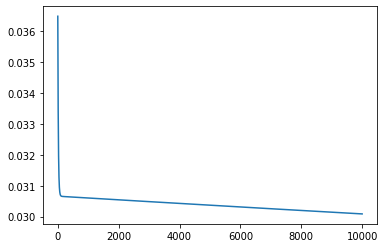

In [8]:
plt.plot(list(range(n_iters)), costs)
plt.show()

In [9]:
print(theta)

[[-0.01848842]
 [ 0.04881776]
 [-0.009395  ]
 [-0.00012962]]


## Using Statsmodels

In [10]:
# Exclude ses_low to make this column a baseline. 
# This prevents multicollinearity.
X = bi_df[['ses_middle', 'ses_high', 'write']]

y = bi_df['prog']

bi_model = sm.Logit(y, sm.add_constant(X))
bi_result = bi_model.fit()

print(bi_result.summary())

Optimization terminated successfully.
         Current function value: 0.649232
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                   prog   No. Observations:                   95
Model:                          Logit   Df Residuals:                       91
Method:                           MLE   Df Model:                            3
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                 0.06148
Time:                        22:06:23   Log-Likelihood:                -61.677
converged:                       True   LL-Null:                       -65.717
Covariance Type:            nonrobust   LLR p-value:                   0.04437
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2091      1.195      1.849      0.065      -0.133       4.551
ses_middle     0.7408      0.

### Interpreting the results

There's a lot to unpack here, so let's go one by one. 

#### Logit Recap
In linear regression, it was easy to interpret what the coefficients meant. Logistic regression is a bit more difficult, as it requires us to understand what the log-odds are.

Recall from the [first part](https://philliplagoc.wordpress.com/2020/06/24/my-take-on-logistic-regression-part-1/) that the log-odds is computed by:
$$logit(p) = log\frac{p}{1 - p}$$

Again, we are simply taking the log of the odds (log-odds!), which allows us to transform the range from $[0, 1]$, which was what the hypothesis outputs, to a range from $[-\infty, \infty]$. There are other ways to do this transformation e.g., probit, but I'll cover that another time. 

In essence, **logistic regression models the logit-transformed probability as a linear relationship with the independent variables**:

$$logit(p) = log\frac{p}{1 - p} = \beta_0 + \beta_1X_1 + \beta_2X_2$$

Solving for $p$ brings us right back to the sigmoid function!

$$\frac{1-p}{p} = \frac{1}{e^{\beta_0 + \beta_1X_1 + \beta_2X_2}}$$

$$\frac{1}{p} = 1 + \frac{1}{e^{\beta_0 + \beta_1X_1 + \beta_2X_2}}$$

$$\frac{1}{p} = \frac{1 + e^{\beta_0 + \beta_1X_1 + \beta_2X_2}}{e^{\beta_0 + \beta_1X_1 + \beta_2X_2}} = \sigma(\theta^Tx)$$

$$p = \frac{e^{\beta_0 + \beta_1X_1 + \beta_2X_2}}{1 + e^{\beta_0 + \beta_1X_1 + \beta_2X_2}} = \sigma(\theta^Tx)$$

#### What do the coefficients mean?

**Note: [This](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/) article was immensely helpful in understanding what these coefficients meant. Check [this](http://blog.yhat.com/posts/logistic-regression-and-python.html) article, too!**

Each coefficient estimate is the expected change in the student's log-odds in the vocational program for each unit increase in the corresponding independent variable while holding the other variables constant.

For every unit increase in the writing score, the log-odds will change by -0.05. The idea is the same as the other variables.

Exponentiating these coefficient estimates will give us the odds of the student being in the vocational program.

In [11]:
print(np.exp(bi_result.params))

const         9.107444
ses_middle    2.097511
ses_high      1.246751
write         0.949620
dtype: float64


For example, we can expect the odds of a student being in the vocational program to **decrease** by about 0.95% for every unit increase in their writing score. 

We can also expect that, if the student has a socioeconomic status categorized as 'middle', the odds of the student being in the vocational program **increases** by about 109%.

# Multinomial Logistic Regression

I will delve into how to implement multinomial logistic regression by hand sometime in the future. For now, `statsmodels` can let us solve multinomial logistic regression problems.

In [12]:
mn_df = orig_df[['prog', 'ses_low', 'ses_middle', 'ses_high', 'write']]
print(mn_df.shape)
mn_df.head()

(200, 5)


,prog,ses_low,ses_middle,ses_high,write
0,1,1,0,0,35.0
1,0,0,1,0,33.0
2,1,0,0,1,39.0
3,1,1,0,0,37.0
4,1,0,1,0,31.0


## Using Statsmodels

In [13]:
# Exclude ses_low to make this column a baseline. 
# This prevents multicollinearity.
X = mn_df[['ses_middle', 'ses_high', 'write']]

y = mn_df['prog']

mn_model = sm.MNLogit(y, sm.add_constant(X))
mn_result = mn_model.fit()

print(mn_result.summary())

Optimization terminated successfully.
         Current function value: 0.899909
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                   prog   No. Observations:                  200
Model:                        MNLogit   Df Residuals:                      192
Method:                           MLE   Df Model:                            6
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                  0.1182
Time:                        22:06:23   Log-Likelihood:                -179.98
converged:                       True   LL-Null:                       -204.10
Covariance Type:            nonrobust   LLR p-value:                 1.063e-08
    prog=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3660      1.174      2.015      0.044       0.065       4.667
ses_middle     0.8247      0.

In [16]:
print(np.exp(mn_result.params))

                    0         1
const       10.654837  0.057718
ses_middle   2.281160  1.704533
ses_high     1.197411  3.198980
write        0.945847  1.059639


### Interpreting the Results

**Note: [This](https://stats.idre.ucla.edu/stata/output/multinomial-logistic-regression-2/) is a really good article for interpreting the coefficients!**

You can see that there are two distinct rows, one signified by `prog=1` and another by `prog=2`. Multinomial logistic regression works by estimating $k - 1$ models, where $k$ is the number of levels in the dependent variable. 

Here, the base group is the general program type i.e., $y = 0$.

Each row represents the two models that are estimated: vocational program type relative to general program type, and academic program type relative to general program type.

In general, the coefficient estimates represent that for a unit change in the respective predictor, the logit of the respective outcome (vocational or academic program type) relative to the general program type is expected to change by however much the coefficient estimate is given the other variables are held constant. 

So, let's unpack some of these coefficients for `prog=1`. 
- If the student has a socioeconomic status of middle i.e., `ses_middle`, then the log-odds of that student being in the vocational program type relative to the general program type would increase by 0.8247. In other words, the odds for that student would **increase** by about 128%. 
- `write` has an estimate of -0.0557. The log-odds would decrease by 0.0557. When exponentiated, this becomes 0.945. So, for every unit increase in the student's writing score, the odds of that student being in the vocational program type relative to the general program type would **decrease** by about 0.95%. 

And again, it's the same idea with `prog=2`.


# Evaluating the results

There are many different ways to evaluate the results of a logistic regression model. I'll go over two ways: a confusion matrix, and a ROC Curve.

## Confusion Matrix

A confusion matrix is a matrix that summarizes the performance of a classification algorithm. It is a $N$x$N$ matrix, where $N$ is the number of classes.

For simplicity, let's look at the confusion matrix for our binary logistic regression, and compare how my model from scratch compares with `statsmodels`. 

The confusion matrix would look something like this:

|                 	| Predicted Positive            	| Predicted Negative             	|
|-----------------	|-------------------------------	|--------------------------------	|
| Actual Positive P	| True Positive                 	| False Negative (Type II Error) 	|
| Actual Negative N	| False Positive (Type I Error) 	| True Negative                  	|


This matrix allows us to compute more metrics:

- **Accuracy**: $\frac{TP + TN}{P + N}$
    - Proportion of correct predictions in the entire data.
- **Precision**: $\frac{TP}{TP + FP}$
    - Of all the positive predictions, how many were right?
- **Specificity**: $\frac{TN}{TN + FN}$
    - Of all the negative predictions, how many were right?
- **Recall/ Sensitivity**: $\frac{TP}{TP + FN}$
    - Of all the positive samples, how many were predicted correctly?
- **F1 Score**: $2 \cdot \frac{prec. * recall}{prec. + recall}$
    - Considering both precision and recall.
    - Very useful for imbalanced data.
    
Let's calculate these metrics!

### My Logistic Regression Model

In [17]:
def decision_boundary(x, threshold = 0.5):
    """
    Returns the classification of the sample for a given threshold
    """
    return 1 if x >= threshold else 0

# Deal with model from scratch
X = bi_df[['ses_low', 'ses_middle', 'ses_high', 'write']]
scratch_probs = bi_hypothesis(X, theta)

scratch_preds = []
for prob in scratch_probs:
    scratch_preds.append(decision_boundary(prob))

# Compare predictions and actuals
tp = 0
tn = 0
fp = 0
fn = 0
for ind, y in enumerate(Y.flatten()):
    if y == 1 and y == scratch_preds[ind]:
        tp += 1
    elif y == 0 and y == scratch_preds[ind]:
        tn += 1
    elif y == 1 and scratch_preds[ind] == 0:
        fn += 1
    elif y == 0 and scratch_preds[ind] == 1:
        fp += 1

In [18]:
print('True Positives: %d' % tp)
print('True Negatives: %d' % tn)
print('False Positives: %d' % fp)
print('False Negatives: %d' % fn)

True Positives: 31
True Negatives: 25
False Positives: 20
False Negatives: 19


In [19]:
print('Accuracy: %.2f' %  ((tp + tn) / len(X))  )
print('Precision: %.2f' % (tp / (tp + fp)) )
print('Specificity: %.2f' % (tn / (tn + fn)) )
print('Recall/ Sensitivity: %.2f' % (tp / (tp + fn)) )
print('F1 Score: %.2f' % ( 2 * (tp / ((tp + fp)) * (tp / (tp + fn))) / (tp / ((tp + fp)) + (tp / (tp + fn))) ) )

Accuracy: 0.59
Precision: 0.61
Specificity: 0.57
Recall/ Sensitivity: 0.62
F1 Score: 0.61


### `statsmodels` Logistic Regression Model

In [20]:
bi_conf_mat = bi_result.pred_table()
print(bi_conf_mat)

[[27. 18.]
 [15. 35.]]


According to the documentation, `pred_table[i, j]` refers to the number of times that class `i` was observed and the model predicted class `j`. Correct predictions are along the diagonal.

Columns represent `j`, or the predicted values. The first column means the model predicted class 0, and the second column means that the model predicted class 1. 

Rows represent `i`, or the actual values. The first row means the sample is class 0, and the second row means that the sample is class 1.

In [21]:
bi_tp = bi_conf_mat[1, 1]
bi_tn = bi_conf_mat[0, 0]
bi_fp = bi_conf_mat[0, 1]
bi_fn = bi_conf_mat[1, 0]
print('True Positives: %d' % bi_tp)
print('True Negatives: %d' % bi_tn)
print('False Positives: %d' % bi_fp)
print('False Negatives: %d' % bi_fn)

True Positives: 35
True Negatives: 27
False Positives: 18
False Negatives: 15


In [22]:
print('Accuracy: %.2f' %  ((bi_tp + bi_tn) / len(X))  )
print('Precision: %.2f' % (bi_tp / (bi_tp + bi_fp)) )
print('Specificity: %.2f' % (bi_tn / (bi_tn + bi_fn)) )
print('Recall/ Sensitivity: %.2f' % (bi_tp / (bi_tp + bi_fn)) )
print('F1 Score: %.2f' % ( 2 * (bi_tp / ((bi_tp + bi_fp)) * (bi_tp / (bi_tp + bi_fn))) / (bi_tp / ((bi_tp + bi_fp)) + (bi_tp / (bi_tp + bi_fn))) ) )

Accuracy: 0.65
Precision: 0.66
Specificity: 0.64
Recall/ Sensitivity: 0.70
F1 Score: 0.68


## ROC Curve

What if we changed the threshold? If we were to alter our threshold, then our predictions would change. For example, increasing our threshold would increase specificity and decrease our recall. In other words, it would be harder for our model to make positive predictions.

If we decreased our threshold, then the exact opposite would happen: our model would have an easier time making positive predictions.

Why would you change the threshold? It depends on the problem. For instance, say we wanted a model that could predict whether or not a patient has cancer. Therefore, false negatives are really, really bad. We don't want to say a patient doesn't have cancer when in fact they do. So, we'd decrease the threshold. We'd be making more false positives, but our recall would increase and false positives aren't as terrible as false negatives. 

We can visually see the impact of changing the threshold using a ROC Curve. Let's do that for the `statsmodels` logistic regression model.

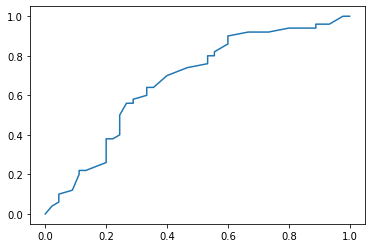

Area Under Curve: 0.67


In [23]:
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve

X = bi_df[['ses_middle', 'ses_high', 'write']]
probs = bi_result.predict(sm.add_constant(X))

# Get fpr, tpr, and thresholds
fpr, tpr, thresholds = roc_curve(Y, probs)

plt.plot(fpr, tpr)

plt.show()

print("Area Under Curve: %.2f" % roc_auc_score(Y, probs))

The ROC Curve is based on the True Positive Rate (TPR) on the Y-axis, and False Positive Rate (FPR) on the X-axis. 

- TPR/ Recall/ Sensitivity
    - $\frac{TP}{TP + FN}$
    
- FPR
    - $1 -$ Specificity $= \frac{FP}{TN + FP}$
    - Of all the negative samples, how many did we predict wrong?

This table shows what happens when we change threshold:

| Threshold 	| Recall/ TPR 	| Specificity 	| FPR = 1 - Specificity 	|
|-----------	|-------------	|-------------	|-----------------------	|
| Increase  	| Decrease    	| Increase    	| Decrease              	|
| Decrease  	| Increase    	| Decrease    	| Increase              	|


The area under the curve tells us how much our model is capable of distinguishing between classes. In this case, it is 0.67. That means there is a 67% chance that the model will be able to distinguish between the positive and negative class. 